In [1]:
from typing import NamedTuple, Sequence

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    MeshRenderer, MeshRasterizer, FoVPerspectiveCameras,
    RasterizationSettings, look_at_view_transform
)

class BlendParams(NamedTuple):
    sigma: float = 1e-4
    gamma: float = 1e-4
    background_color: Sequence = (1, 1, 1)

In [2]:
device = torch.device("cuda:0")
device = 'cpu'
meshes = load_objs_as_meshes(['data/cow_mesh/cow.obj'], device=device)

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/jorge/.conda/envs/texture/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/jorge/.conda/envs/texture/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


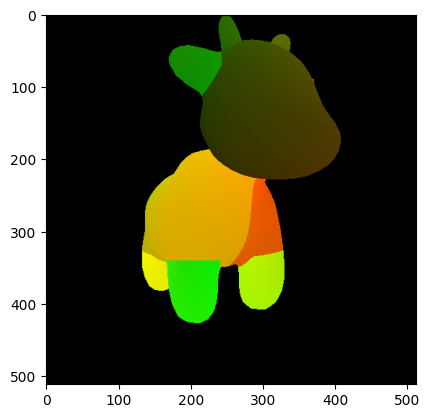

In [87]:
from einops import rearrange, reduce
from pytorch3d.ops import interpolate_face_attributes
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.renderer import AmbientLights, SoftPhongShader, TexturesUV

R, T = look_at_view_transform(dist=2, azim=150, elev=0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60)

raster_settings = RasterizationSettings(image_size=512, faces_per_pixel=1)
rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)

lights = AmbientLights(device=device)
shader = SoftPhongShader(
    cameras=cameras,
    lights=lights,
    device=device,
    blend_params=BlendParams()
)

renderer = MeshRenderer(
    rasterizer=rasterizer,
    shader=shader
)

fragments: Fragments = renderer.rasterizer(meshes)

# get UV coordinates for each pixel
texture: TexturesUV = meshes.textures
texture_map = texture.maps_list()[0]
verts_uvs = texture.verts_uvs_list()[0]
faces_uvs = texture.faces_uvs_list()[0]

# face_attributes: packed attributes of shape (total_faces, 3, D),
# specifying the value of the attribute for each
#     vertex in the face.

# (F, 3, 2) for each face, for each vert a uv coord
face_vert_uvs = verts_uvs[faces_uvs]

# interpolate uv coords to obtain pixel-uvs
pixel_uvs = interpolate_face_attributes(
    fragments.pix_to_face,
    fragments.bary_coords,
    face_vert_uvs
)

# (H, W, 2)
pixel_uvs = rearrange(pixel_uvs, '1 h w 1 d -> h w d')

# add empty channel to make it RGB for visualization purposes
pixel_uvs_rgb = torch.cat([pixel_uvs, torch.zeros(pixel_uvs.shape[0], pixel_uvs.shape[1], 1).to(pixel_uvs)], dim=2)

plt.imshow(pixel_uvs_rgb.cpu())

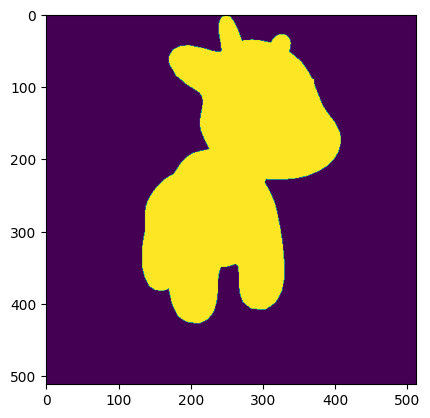

In [88]:
# values that 
mask = ~torch.all(pixel_uvs == 0, dim=-1)
plt.imshow(mask.cpu())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


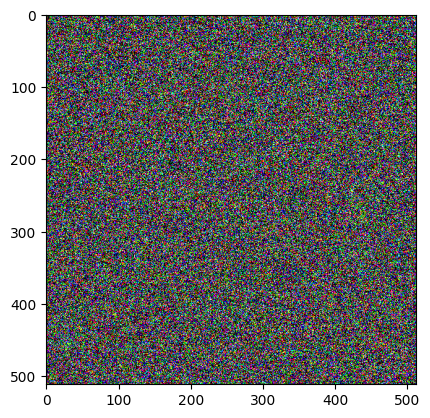

In [89]:
view = torch.randn(pixel_uvs.shape[0], pixel_uvs.shape[1], 3)
plt.imshow(view)

In [90]:
# uv coords of each pixel that is not masked
projected_uvs = pixel_uvs[mask]
indices = torch.nonzero(mask)

projected_uvs


tensor([[0.1645, 0.4226],
        [0.1652, 0.4233],
        [0.1656, 0.4243],
        ...,
        [0.1315, 0.9417],
        [0.1309, 0.9420],
        [0.1308, 0.9433]])

In [73]:
uv_size = 1024

y_values = (1 - projected_uvs[:, 1]) * (uv_size - 1)
x_values = projected_uvs[:, 0] * (uv_size - 1)

y_0 = torch.floor(y_values)
y_1 = torch.ceil(y_values)
x_0 = torch.floor(x_values)
x_1 = torch.ceil(x_values)

ys, xs = torch.cat([y_0, y_0, y_1, y_1], 0).long(), torch.cat([x_0, x_1, x_0, x_1], 0).long()

ys.shape


torch.Size([264596])

In [91]:
new_texture = texture_map.clone()

# texel coords of ach projected value
texture_coords = (projected_uvs*1024).to(int)

new_texture[ys, xs] = 0

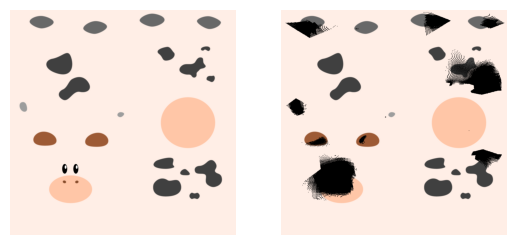

In [92]:
fig, axs = plt.subplots(1,2)

for ax in axs:
    ax.axis('off')

axs[0].imshow(texture_map.cpu())
axs[1].imshow(new_texture.cpu())
